In [602]:
import os
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "" # Delete above if you want to use GPU
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
import sys
from datetime import datetime
html_width(HTML("<style>.container { width:90% !important; }</style>"))

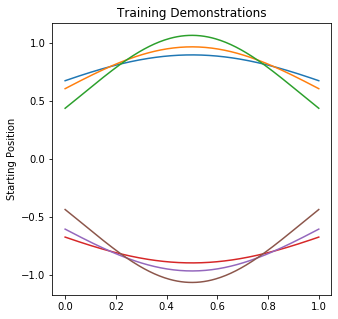

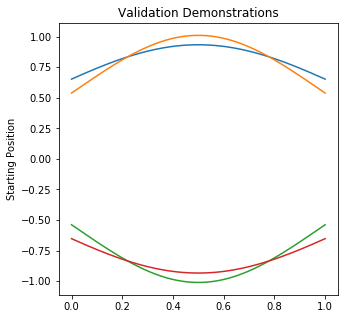

training X  (6, 200, 1)
training Y  (6, 200, 1)
validation X  (4, 200, 1)
validation Y  (4, 200, 1)


In [628]:
def dist_generator(d, x, param, noise = 0):
    f = (math.exp(-x**2/(2.*param[0]**2))/(math.sqrt(2*math.pi)*param[0]))+(math.exp(-x**2/(2.*(param[0]*2)**2))/(math.sqrt(2*math.pi)*param[0]*2))+param[1]
    return f+(noise*(np.random.rand()-0.5)/100.)

def generate_demonstrations(time_len = 200, params = None, title = None):
    fig = plt.figure(figsize=(5,5))
    x = np.linspace(-0.5,0.5,time_len)
    times = np.zeros((params.shape[0],time_len,1))
    times[:] = x.reshape((1,time_len,1))+0.5
    values = np.zeros((params.shape[0],time_len,1))
    for d in range(params.shape[0]):
            for i in range(time_len):
                values[d,i] = dist_generator(d,x[i],params[d])
            plt.plot(times[d], values[d])
    plt.title(title+' Demonstrations')
    plt.ylabel('Starting Position')
    plt.show()
    return times, values

X, Y = generate_demonstrations(time_len=200, params=np.array([[0.6,-0.1],[0.5,-0.23],[0.4,-0.43],[-0.6,0.1],[-0.5,0.23],[-0.4,0.43]]), title='Training')
v_X, v_Y = generate_demonstrations(time_len=200, params=np.array([[0.55,-0.155],[0.45,-0.32],[-0.45,0.32],[-0.55,0.155]]), title='Validation')
print( 'training X ', X.shape )
print( 'training Y ',Y.shape )
print( 'validation X ', v_X.shape )
print( 'validation Y ',v_Y.shape )
np.save('training_X',X)
np.save('training_Y',Y)
np.save('validation_X',v_X)
np.save('validation_Y',v_Y)

In [629]:
#Loading demonstrations and necessary variables
X, Y = (np.load('training_X.npy'), np.load('training_Y.npy'))
v_X, v_Y = (np.load('validation_X.npy'), np.load('validation_Y.npy'))
obs_max = 5 
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])
time_len = X.shape[1] 
obs_mlp_layers = [128,128,128]
decoder_layers = [128,128,d_y*2]

print( 'd_N=', d_N )
print( 'obs_max=', obs_max )
print( 'X',X.shape,', Y',Y.shape )
print( 'd_x=',d_x )
print( 'd_y=',d_y )
print( 'time_len=', time_len )

d_N= 6
obs_max= 5
X (6, 200, 1) , Y (6, 200, 1)
d_x= 1
d_y= 1
time_len= 200


In [630]:
def get_train_sample():
    n = np.random.randint(0,obs_max)+1
    d = np.random.randint(0, d_N)
    observation = np.zeros((1,n,d_x+d_y)) 
    target_X = np.zeros((1,1,d_x))
    target_Y = np.zeros((1,1,d_y*2))
    perm = np.random.permutation(time_len)
    observation[0,:n,:d_x] = X[d,perm[:n]]
    observation[0,:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0,0] = X[d,perm[n]]
    target_Y[0,0,:d_y] = Y[d,perm[n]]
    return [observation,target_X], target_Y

In [631]:
def predict_model(observation, target_X, plot = True):
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    prediction = model(torch.tensor(observation).float(),torch.tensor(target_X).float()).data.numpy()[0]
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                plt.plot(X[j,:,0],Y[j,:,i]) # assuming X[j,:,0] is time
            plt.plot(X[j,:,0],predicted_Y[:,i],color='black')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.scatter(observation[0,:,0],observation[0,:,d_x+i],marker="X",color='black')
            plt.show()  
    return predicted_Y, predicted_std

In [632]:
def custom_loss(y_true, y_predicted):
    mean, log_sigma = torch.split(y_predicted, 1, dim=2)
    y_true_value, _ = torch.split(y_true, 1, dim=2)
    sigma = F.softplus(log_sigma)
    dist = torch.distributions.MultivariateNormal(mean, scale_tril=torch.diag(sigma.view(sigma.nelement())))
    loss = -torch.mean(dist.log_prob(y_true_value))
    return loss

In [633]:
class ObsMLP(nn.Module):
    def __init__(self):
        super(ObsMLP, self).__init__()
        
        self.input2first = nn.Linear(d_x+d_y, 128)
        self.first2second = nn.Linear(128, 128)
        self.second2output = nn.Linear(128, 128)
        
    def forward(self, data):
        hidden = F.relu( self.input2first(data) )
        hidden = F.relu( self.first2second(hidden) )
        hidden = self.second2output(hidden)
        return hidden

class DecoderMLP(nn.Module):
    def __init__(self, module, batch_first=False):
        super(DecoderMLP, self).__init__()
        self.module = module
        self.batch_first = batch_first
        
        self.input2first = nn.Linear(128+1, 128)
        self.first2second = nn.Linear(128, 128)
        self.second2output = nn.Linear(128, d_y*2)
        
    def forward(self, x, y):
        
        x = self.module(x, y)
        hidden = F.relu( self.input2first(x) )
        hidden = F.relu( self.first2second(hidden) )
        hidden = self.second2output(hidden)
        
        return hidden

In [634]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        # if no time distributed input
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
    
        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y
    
class mean(nn.Module):
    def __init__(self, module, batch_first=False):
        super(mean, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        r_is = self.module(x)
        return r_is.mean(axis=1)
    
class repeat_and_merge(nn.Module):
    def __init__(self, module, batch_first=False):
        super(repeat_and_merge, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x, y):
        r = self.module(x)
        r = r.repeat(1, y.size(1), 1)
        return torch.cat((r, y), 2)

In [635]:
obs_mlp = ObsMLP() # network e

obs_representations = TimeDistributed(obs_mlp) # r_i's

general_representation = mean(obs_representations) # r

merged_layer = repeat_and_merge(general_representation)

decoder = DecoderMLP(merged_layer)

model = decoder

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

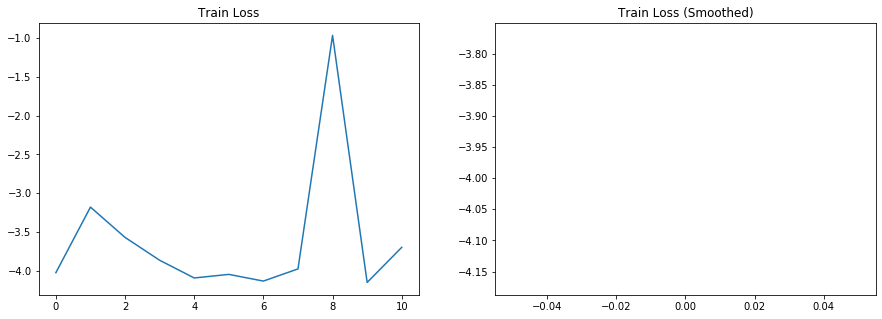

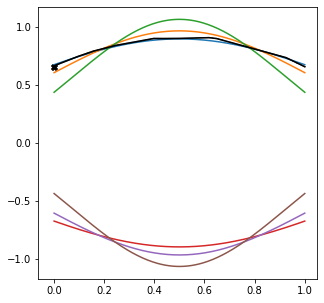

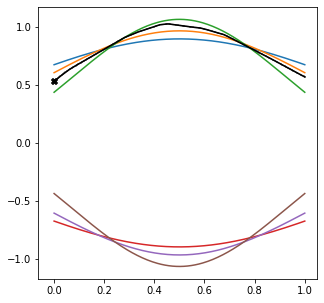

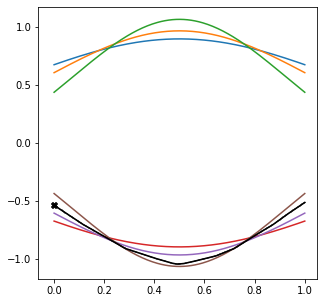

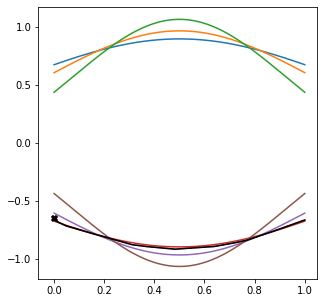

 Iteration: 16061,  Elapsed: 0:01:30,  ETA: 3:19:44.377020,  01.61 % is completed,  loss=-3.68,  error=0.00018658   

KeyboardInterrupt: 

In [642]:
times_between_epoches = [None]*1000
i_tbe = 0
starttime = datetime.now()
lasttime = starttime
max_training_step = 1000000

def getInformationString(iterationNu, loss, error, printlog):
    now = datetime.now()
    
    global i_tbe, lasttime
    if iterationNu%1000 == 1:
        i_tbe = 0
    times_between_epoches[i_tbe] = now-lasttime
    lasttime = now
    i_tbe = 1
    mean_tbe = times_between_epoches[0]
    s_tbe = 1
    '''for i in range(1, 1000):
        if times_between_epoches[i] is not None:
            mean_tbe += times_between_epoches[i]
            s_tbe += 1
    '''
    mean_tbe /= s_tbe
        
    eta = str(1.0*(max_training_step-iterationNu)*mean_tbe)
    return "Iteration: %5d,  Elapsed: %s,  ETA: %s,  %05.2lf %% is completed,  loss=%.2lf,  error=%.8lf" % (iterationNu, str(now-starttime)[:-7], eta, 100.0*iterationNu/max_training_step, loss, error) + "   " + printlog

try:
    parameters = torch.load("cnmp_best_validation.h5")
    model.load_state_dict(parameters)
    
    print("Parameter are loaded from best validation file")
except:
    
    print("There are no best validation file")
    pass

time.sleep(4)


alpha = 1e-6

optimizer = optim.Adam(model.parameters(), lr=alpha)
callback = CNMP_Callback()

callback.on_train_begin()

for iteration in range(0,max_training_step):
    
    lasttime = datetime.now()
    
    [observation, target_x], target_y = get_train_sample()
    
    observation = torch.tensor(observation).float()
    target_x = torch.tensor(target_x).float()
    target_y = torch.tensor(target_y).float()
    
    optimizer.zero_grad()   # zero the gradient buffers
    
    output = model(observation, target_x)
    loss = custom_loss(target_y, output)
    
    loss.backward()
    optimizer.step()
    
    printlog = callback.on_batch_end(logs={'loss': loss.item()})
    
    if iteration%20==0:
        print('\x08' * 200, flush=True, end="")
        print("\r", getInformationString(iteration+1, loss.item(), callback.last_validation_error, printlog), end="", flush=True)
        if len(printlog):
            print("")
    




In [617]:
class CNMP_Callback:
    def on_train_begin(self, logs={}):
        self.smooth_losses = [0]
        self.losses = []
        self.step = 0
        self.loss_checkpoint = 1000
        self.plot_checkpoint = 10000
        self.validation_checkpoint = 100
        self.validation_error = 9999999
        
        current_error = 0
        for i in range(v_X.shape[0]):
            # predicting whole trajectory by using the first time step of the ith validation trajectory as given observation
            predicted_Y,predicted_std = predict_model(np.concatenate((v_X[i,0],v_Y[i,0])).reshape(1,1,d_x+d_y), v_X[i].reshape(1,time_len,d_x), plot= False)
            current_error += np.mean((predicted_Y - v_Y[i,:])**2) / v_X.shape[0]
        self.validation_error = current_error
        self.last_validation_error = current_error
        
        return

    def on_batch_end(self, logs={}):
        
        printlog = ""
        
        if self.step % self.validation_checkpoint == 0:
            ### Here, you should customize our own validation function according to your data and save your best model ###
            current_error = 0
            for i in range(v_X.shape[0]):
                # predicting whole trajectory by using the first time step of the ith validation trajectory as given observation
                predicted_Y,predicted_std = predict_model(np.concatenate((v_X[i,0],v_Y[i,0])).reshape(1,1,d_x+d_y), v_X[i].reshape(1,time_len,d_x), plot= False)
                current_error += np.mean((predicted_Y - v_Y[i,:])**2) / v_X.shape[0]
            self.last_validation_error = current_error
            if current_error < self.validation_error:
                self.validation_error = current_error
                torch.save(model.state_dict(), 'cnmp_best_validation.h5')
                printlog += ' New validation best. Error is ' + str(current_error)
            ### If you are not using validation, please note that every large-enough nn model will eventually overfit to the input data ###
            
        if self.step % self.loss_checkpoint == 0:
            self.losses.append(logs.get('loss'))
            self.smooth_losses[-1] += logs.get('loss')/(self.plot_checkpoint/self.loss_checkpoint)
            
        if self.step % self.plot_checkpoint == 0:
            print(self.step)
            #clearing output cell
            display.clear_output(wait=True)
            display.display(pl.gcf())
            
            #plotting training and smoothed losses
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            plt.title('Train Loss')
            plt.plot(range(len(self.losses)),self.losses)
            plt.subplot(122)
            plt.title('Train Loss (Smoothed)')
            plt.plot(range(len(self.smooth_losses)),self.smooth_losses)
            plt.show()
            
            #plotting on-train examples by user given observations
            for i in range(v_X.shape[0]):
                #for each validation trajectory, predicting and plotting whole trajectories by using the first time steps as given observations. 
                predict_model(np.concatenate((v_X[i,0],v_Y[i,0])).reshape(1,1,d_x+d_y), v_X[i].reshape(1,time_len,d_x))
            
            if self.step!=0:
                self.smooth_losses.append(0)
            
        self.step += 1
        return printlog